# 环境准备

## 给已存在的容器master、slave1 、slave2 添加端口映射的方法

1. 查找当前容器 id 和 ip

在PowerShell终端中依次输入:

2.  容器配置文件地址

首先得找到容器配置文件地址，容器的配置文件目录在：

在PowerShell终端中依次输入:

3. 文件夹的名字是相应的容器ID

打开对应发行版的 WSL 网络位置之后，文件夹的名字是相应的容器ID，打开后修改其中的 config.v2.json 和 hostconfig.json，用 Windows 的记事本都可以。

- 修改：config.v2.json ：

slave1 8650：

slave2 8651:

- 修改： hostconfig.json

slave1 8650:

slave2 8651:

4. 重启Docker服务

要重启整个Docker服务，不是直接去 Docker Desktop 重启 Container （如果你不小心启动了 Container ，上面的配置会被还原，请你再改一次，然后这次就不要忘记 Restart Docker 服务了），在系统右下角，重启整个 Docker 服务，然后再重启 Container 即可正常使用。

## 开启集群

##  系统环境 

- Ubuntu server 18.04
- 安装gmetad的机器：master
- 安装gmond的机 器：master,slave1,slave2
- 浏览监控web页面的机器：master

# Ganglia监控

## 介绍 

Ganglia 监控套件包括三个主要部分：gmond，gmetad，和网页接口，通常被称为ganglia- web。
- gmond 是一个守护进程，他运行在每一个需要监测的节点上，收集监测统计，发送和接受在同一个组播或单播通道上的统计信息。gmond（Ganglia Monitoring Daemon）是一种轻量级服务，安装在每台需要收集指标数据的节点主机上。使用 gmond，可以收集很多系统指标数据，如 CPU、内存、磁盘、网络和活跃进程数据等。
- gmetad 也是一个守护进程，他定期检查 gmonds ，从那里拉取数据，并将他们的指标存储在RRD存储引擎中。它可以查询多个集群并聚合指标。RRD也被用于生成用户界面的web前端。gmetad（Ganglia Meta Daemon）整合所有信息，并将其以 RDD 格式存储至磁盘的服务。
- ganglia-web 顾名思义，他应该安装在有gmetad运行的机器上，以便读取RRD文件。gweb（Ganglia Web）是 Ganglia 可视化工具，gweb 是一种利用浏览器显示 gmetad 所存储的数据的 PHP 前端。在 Web 页面中以图表的方式展现集群的运行状态下收集的多种不同指标数据。

一般来说一个集群的每台机器上都需要安装gmond，只要负责展示web界面的机器安装了gmetad即可。

## 安装 

1. apt-get方式安装

首先找一个结点当作web显示的结点，使用以下命令一键安装：

除了安装 ganglia-webfrontend 的主机，其他主机只需要安装 ganglia-monitor 即可。

2. 链接到web服务器

安装 ganglia-webfrontend 的时候就已经安装了Apache Web Server，Ganglia-webfrontend默认安装的位置是/usr/share/ganglia-webfront，现在还不能通过浏览器 访问Ganglia监控界面，需要执行以下命令将将ganglia的文件链接到apache的默认目录下。

## 单播与组播

在进行Ganglia集群配置之前，首先要搞清楚单播和组播。

- 单播：可以跨网段传播，只将信息发送给指定的机器。要配置成为单播你应该指定一个（或者多个）接受的主机。
- 组播：在机器所处的网段中发送广播，发送给位于同一网段的所有机器。如果你正在使用组播传输，那么你没必要改变任何东西，因为这是Ganglia 包安装默认的。唯一要做的就是把gmetad指向一个或几个运行着gmond的主机。没有必要列出每一个单个主机，因为gmond被设置为接受模式时会包含所有主机的列表以及整个集群的统计信息。

关于单播和组播更详细的介绍和相关配置请参照：Ganglia快速开始向导（翻译自官方wiki）  http://www.linuxidc.com/Linux/2013-11/92747.htm ，或者直接查看官方wiki http://sourceforge.net/apps/trac/ganglia/wiki/ganglia_quick_start 。

# 集群配置

我的Ganglia监控集群使用了单播模式。所有的配置都在/etc/ganglia目录下，在每个节点上都要配置/etc/ganglia/gmond.conf.

## 主节点配置

1. 复制 Ganglia webfrontend Apache 配置

2. 编辑 Ganglia 元守护程序的配置文件

更改如下位置：

修改为：

同时，可设置多个data_source，建议将不同功能的机器放到不同的分组中。。。。例如

这里，不同分组要用不同的端口号！！

4. 编辑主节点的配置文件

做下面的变化：

其中data_source分组与端口号要保持一直

保存并关闭文件。

## 客户机配置

1.  安装以下所有服务器要监视客户端包

2. 编辑客户节点的配置文件gmond.conf，这里和主节点的一致就行，但是如果有多个分组，那个分组名要和端口号保持一致

xsync /etc/ganglia/gmond.conf

## 启动Ganglia

## 检验

说明：如果完成以上操作依然出现权限不足错误，需修改/var/lib/ganglia 目录的权限：

```
chmod -R 777 /var/lib/ganglia
```

登录浏览器查看：http://master/ganglia/ ，如果 Hosts up为9即表示安装成功。

若安装不成功，有几个很有用的调试命令：

以调试模式启动 gmetad：gmetad -d 9

查看gmetad收集到的XML文件：telnet master 8649

#  监控Hadoop集群

# Flume 数据流监控

1. 修改 /opt/module/flume/conf 目录下的 flume-env.sh 配置

```
JAVA_OPTS="-Dflume.monitoring.type=ganglia
-Dflume.monitoring.hosts=master:8649
-Xms100m
-Xmx200m"

```
2. 启动 Flume 任务

```
bin/flume-ng agent -c conf -f job/flume-netcat-logger.conf -n a1 \
-Dflume.root.logger==INFO,console \ 
-Dflume.monitoring.type=ganglia \ 
-Dflume.monitoring.hosts=master:8649

```
3. 发送数据观察 Ganglia 监测图

```
nc localhost 44444
```


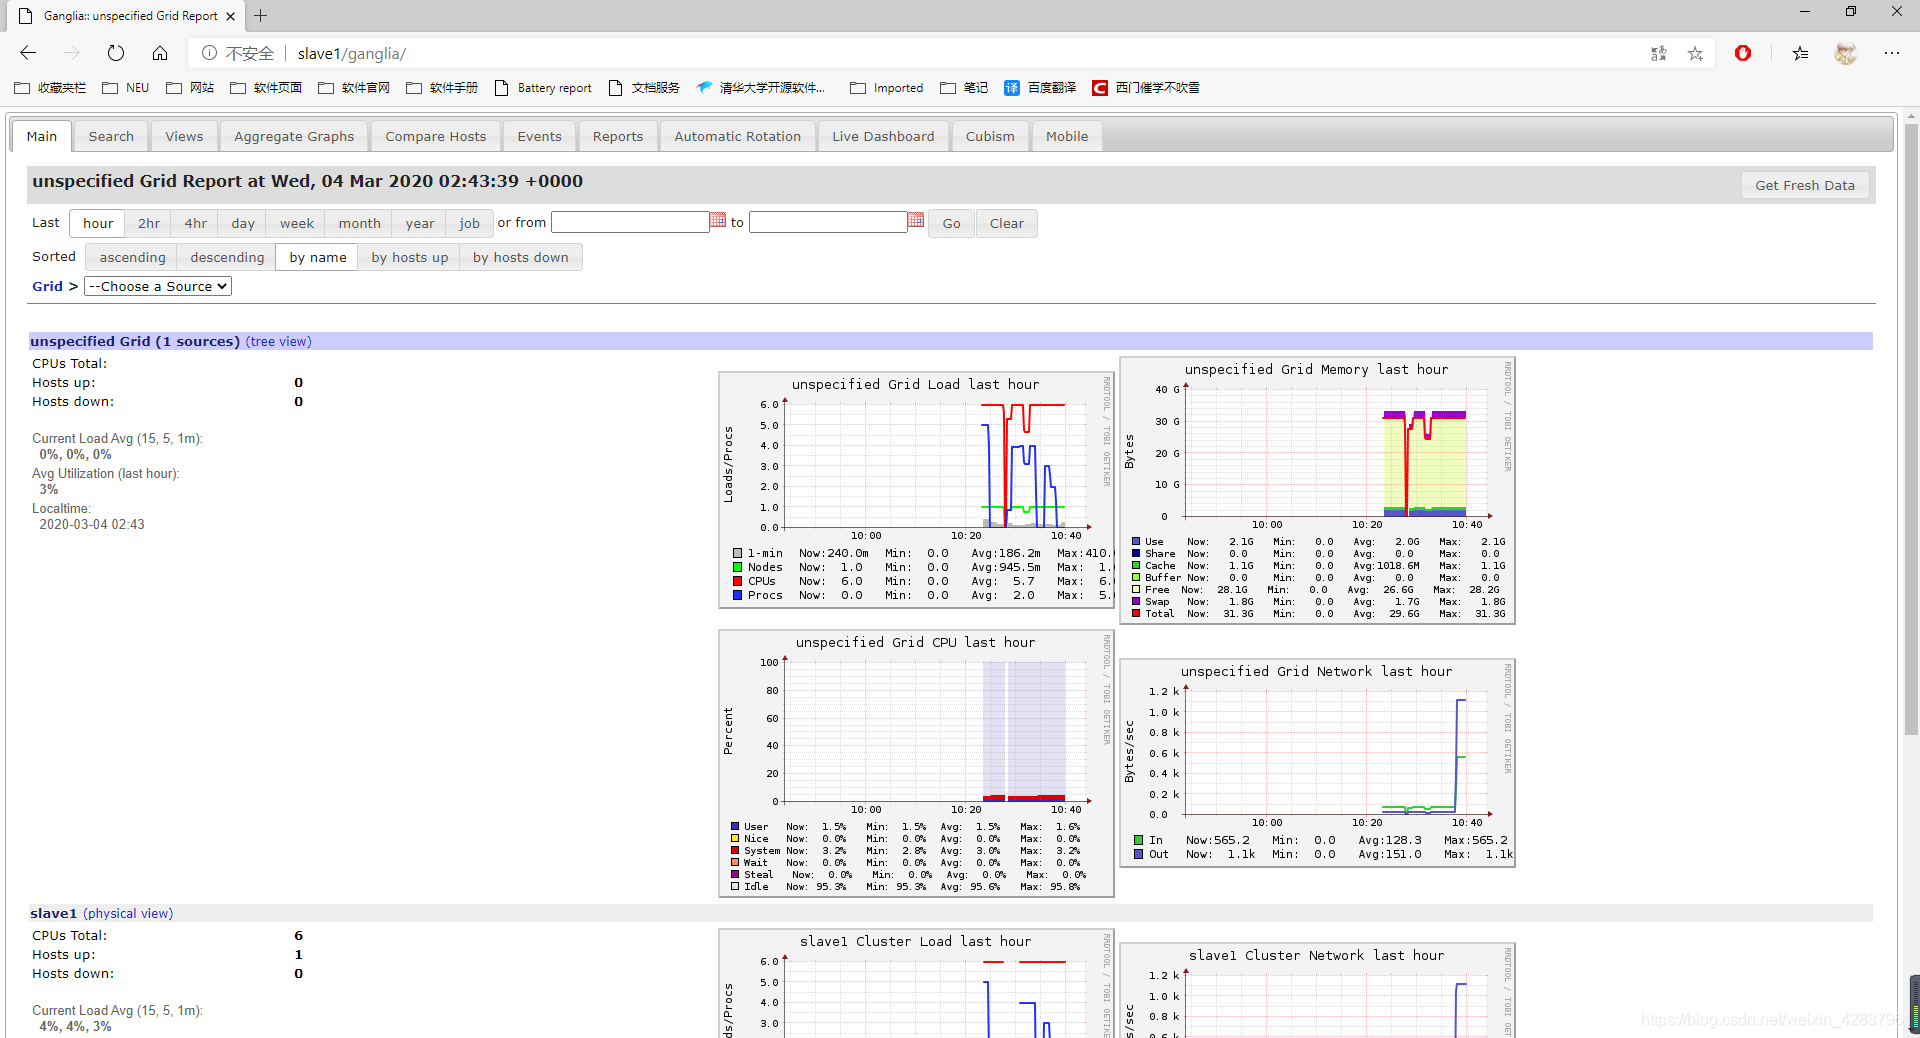

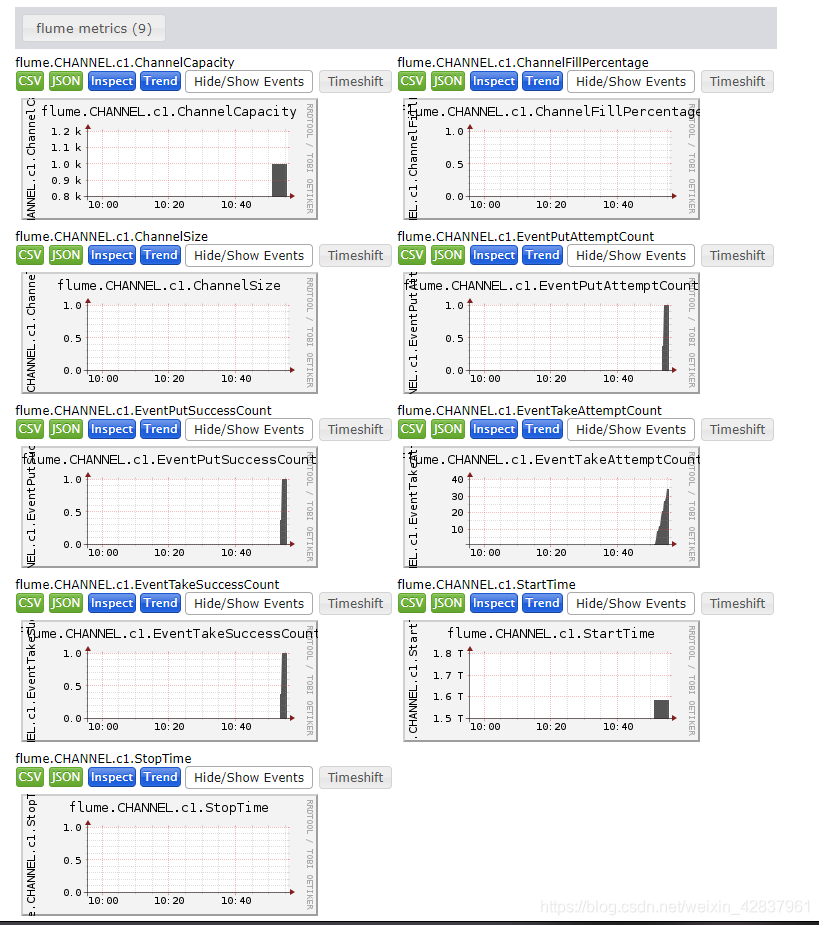

<table><thead><tr><th>字段</th><th>字段含义</th><th>字段</th><th>字段含义</th></tr></thead><tbody><tr><td>ChannelCapacity</td><td>channel 的容量</td><td>ChannelFillPercentage</td><td>channel 占用的百分比</td></tr><tr><td>ChannelSize</td><td>目前 channel 中事件的总数量</td><td>EventPutAttemptCount</td><td>source 尝试写入 channel 的事件总数量</td></tr><tr><td>EventPutSuccessCount</td><td>成功写入 channel 且提交的事件总数量</td><td>EventTakeAttemptCount</td><td>sink 尝试从 channel 拉取事件的总数量。</td></tr><tr><td>EventTakeSuccessCount</td><td>sink 成功读取的事件的总数量</td><td>StartTime</td><td>channel 启动的时间（毫秒）</td></tr><tr><td>StopTime</td><td>channel 停止的时间（毫秒）</td><td></td><td></td></tr></tbody></table>